In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42) 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
df = pd.read_csv('Survival_dataset.csv')

In [4]:
df

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,132539,6,1,5,-1,0,54.0,0.0,NaN,NaN,...,NaN,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN
1,132540,16,8,8,-1,0,76.0,1.0,175.3,76.0,...,103.0,NaN,NaN,13.3,81.6,7.37,71.0,360.0,0.0,5.0
2,132541,21,11,19,-1,0,44.0,0.0,NaN,56.7,...,126.0,NaN,NaN,6.2,56.7,7.47,617.0,2160.0,1.0,14.0
3,132543,7,1,9,575,0,68.0,1.0,180.3,84.6,...,NaN,NaN,NaN,7.9,84.6,NaN,NaN,NaN,NaN,NaN
4,132545,17,2,4,918,0,88.0,0.0,NaN,NaN,...,NaN,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,142665,19,7,10,336,0,70.0,0.0,NaN,87.0,...,152.0,NaN,NaN,17.5,NaN,7.39,23.0,1200.0,0.0,6.0
3996,142667,8,2,3,-1,0,25.0,1.0,NaN,166.4,...,NaN,NaN,NaN,3.0,166.4,NaN,NaN,NaN,NaN,NaN
3997,142670,8,5,11,-1,0,44.0,1.0,NaN,109.0,...,113.0,NaN,NaN,10.6,109.0,7.41,80.0,2580.0,1.0,15.0
3998,142671,22,10,8,7,1,37.0,1.0,NaN,87.4,...,145.0,NaN,NaN,11.5,87.4,7.34,82.0,2585.0,1.0,15.0


In [5]:
df.describe()

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,3997.000000,2106.000000,3669.000000,...,2780.000000,205.000000,863.000000,3908.000000,2718.000000,3038.000000,2529.000000,2529.000000,2529.000000,2529.000000
mean,137605.122000,14.203500,6.402500,13.441750,128.735500,0.138500,64.247500,0.561921,171.985856,81.474832,...,122.461871,6.466341,1.002283,12.303224,85.037344,7.398693,285.176750,1912.005140,0.620799,12.314749
std,2923.608886,6.088584,4.201298,12.246371,363.714273,0.345467,17.560946,0.496213,83.781865,23.305130,...,23.676777,9.594861,2.395043,6.591505,24.090094,0.061213,484.275957,872.032383,0.485284,5.896841
min,132539.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,15.000000,0.000000,121.900000,35.000000,...,7.000000,0.300000,0.010000,1.000000,35.000000,7.030000,0.000000,0.000000,0.000000,1.000000
25%,135075.750000,11.000000,3.000000,6.000000,-1.000000,0.000000,52.750000,0.000000,162.600000,66.000000,...,106.000000,0.700000,0.040000,8.500000,68.500000,7.370000,53.000000,1170.000000,0.000000,8.000000
50%,137592.500000,15.000000,6.000000,10.000000,-1.000000,0.000000,67.000000,1.000000,170.200000,78.700000,...,121.000000,2.000000,0.130000,11.200000,82.200000,7.400000,122.000000,2320.000000,1.000000,13.000000
75%,140100.250000,18.000000,9.000000,17.000000,16.000000,0.000000,78.000000,1.000000,177.800000,92.000000,...,138.000000,7.900000,0.760000,14.800000,97.600000,7.440000,242.000000,2670.000000,1.000000,16.000000
max,142673.000000,34.000000,22.000000,154.000000,2600.000000,1.000000,90.000000,1.000000,3960.000000,280.000000,...,260.000000,49.200000,24.040000,162.000000,280.000000,7.660000,2859.000000,2870.000000,1.000000,44.000000


In [6]:
df.columns

Index(['recordid', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival',
       'In-hospital_death', 'Age', 'Gender', 'Height', 'Weight',
       ...
       'SysABP_last', 'TroponinI_last', 'TroponinT_last', 'WBC_last',
       'Weight_last', 'pH_last', 'MechVentStartTime', 'MechVentDuration',
       'MechVentLast8Hour', 'UrineOutputSum'],
      dtype='object', length=120)

In [7]:
df.isna().sum()

recordid                0
SAPS-I                  0
SOFA                    0
Length_of_stay          0
Survival                0
                     ... 
pH_last               962
MechVentStartTime    1471
MechVentDuration     1471
MechVentLast8Hour    1471
UrineOutputSum       1471
Length: 120, dtype: int64

In [8]:
target_variable = 'In-hospital_death'
X = df.drop([target_variable, "recordid", "SAPS-I", "SOFA", "Length_of_stay", "Survival"], axis=1)
y = df[target_variable]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [10]:
y_train.value_counts()

In-hospital_death
0    2767
1     433
Name: count, dtype: int64

In [11]:
y_test.value_counts()

In-hospital_death
0    679
1    121
Name: count, dtype: int64

# Preprocessing

In [12]:
def preprocess_data(data, drop_threshold=0.5):
    # Drop columns with nan ratio > threshold
    count = data.isna().sum()
    cols_to_drop = data.columns[count / len(data) > drop_threshold]
    data = data.drop(columns=cols_to_drop)

    # Select numeric columns
    numeric_columns = data.select_dtypes(exclude=['object']).columns

    # Impute missing values using KNNImputer
    imputer = SimpleImputer(strategy = "median")
    data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

    # Check for any remaining missing values after imputation
    if data[numeric_columns].isnull().any().any():
        raise ValueError("There are still missing values after imputation.")

    # Standardize numeric columns using StandardScaler
    scaler = StandardScaler()
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    # Check if the number of columns after scaling matches the original numeric columns
    if len(numeric_columns) != data[numeric_columns].shape[1]:
        raise ValueError("The number of columns after scaling doesn't match the original numeric columns.")

    return data

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

## Handle imbalaced data (resample)

In [13]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN

def resample_data(X, y, method='random'):
    if method == 'random':
        oversampler = RandomOverSampler(sampling_strategy=0.35)
    elif method == 'smote':
        oversampler = SMOTE(sampling_strategy=0.5)
    elif method == 'adasyn':
        oversampler = ADASYN(sampling_strategy=0.5)
    elif method == 'borderline_smote':
        oversampler = BorderlineSMOTE(sampling_strategy=0.5)
    elif method == 'smote_enn':
        oversampler = SMOTEENN(sampling_strategy=0.2)
    else:
        raise ValueError("Invalid resampling method.")

    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

#X_train, y_train = resample_data(X_train, y_train, method='smote')
#X_test, y_test = resample_data(X_test, y_test, method='random')

In [14]:
y_train.value_counts()

In-hospital_death
0    2767
1     433
Name: count, dtype: int64

In [15]:
y_test.value_counts()
# shat annshan em weight tvel, uxxaki ahreli mec er tarberutyuny

In-hospital_death
0    679
1    121
Name: count, dtype: int64

## Imbalance handling models

Accuracy: 0.795
Precision: 0.400
Recall: 0.711
F1 Score: 0.512

Confusion Matrix:
[[550 129]
 [ 35  86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       679
           1       0.40      0.71      0.51       121

    accuracy                           0.80       800
   macro avg       0.67      0.76      0.69       800
weighted avg       0.86      0.80      0.82       800

AUC-ROC: 0.8460546014435424


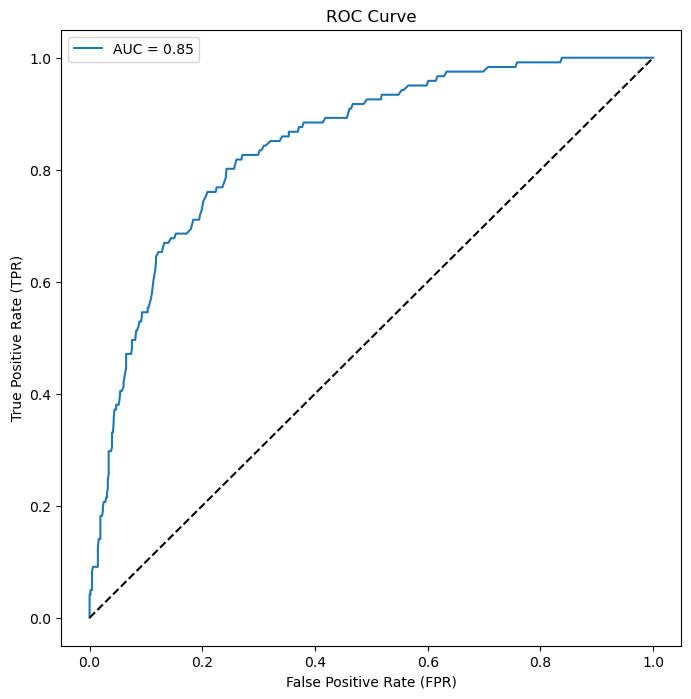

In [17]:
brf = BalancedRandomForestClassifier(
    n_estimators=500, random_state=42, sampling_strategy="all", replacement=True,
    bootstrap=True,
)
brf.fit(X_train, y_train)
y_pred_prob = brf.predict_proba(X_test)[:, 1]

threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)
print(f'AUC-ROC: {roc_auc}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()
